<a href="https://colab.research.google.com/github/mmatera/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy

  Using cached matplotlib_inline-0.1.3-py3-none-any.whl (8.2 kB)


In [19]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import pickle
import math, cmath
import proj_ev_tools as me

from IPython.display import display, Math, Latex

In [20]:
N = 3            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [21]:
## Operadores de spin y hamiltoniano
spin_list = me.one_body_spin_ops(N)
sx_list = spin_list[0]
sy_list = spin_list[1]
sz_list = spin_list[2]

In [22]:
def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h):
    H = 0;
    for n in range(N):
        H += -0.5*h[n]*sz_list[n]
        
    for n in range(N-1):
        H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
    return H

H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)
H_H

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-4.86946861  0.          0.          0.07853982  0.          0.
   0.07853982  0.        ]
 [ 0.         -1.57079633 -0.31415927  0.          0.          0.
   0.          0.07853982]
 [ 0.         -0.31415927 -1.41371669  0.         -0.31415927  0.
   0.          0.        ]
 [ 0.07853982  0.          0.          1.57079633  0.         -0.31415927
   0.          0.        ]
 [ 0.          0.         -0.31415927  0.         -1.57079633  0.
   0.          0.07853982]
 [ 0.          0.          0.         -0.31415927  0.          1.72787596
  -0.31415927  0.        ]
 [ 0.07853982  0.          0.          0.          0.         -0.31415927
   1.57079633  0.        ]
 [ 0.          0.07853982  0.          0.          0.07853982  0.
   0.          4.55530935]]

In [23]:
## Free particles-Operators en términos de los operadores de spin
fplists = me.free_particle_ops(N, H_H, sz_list)

x_op = fplists[0]
p_op = fplists[1]
comm_xp = fplists[2]
corr_xp = fplists[3]
p_dot = fplists[4]

In [24]:
# Estas definiciones quedaron obsoletas pero sirven para el testeo de la n_body_basis

globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
globalid_list = []
for i in range(N):
    globalid_list.append(globalid)

one_site_basis = globalid_list + sx_list + sy_list + sz_list 
two_site_basis = [op1*op2 for op1 in one_site_basis for op2 in one_site_basis]

tercera_base = [op*op3 for op in two_site_basis for op3 in one_site_basis]
three_site_basis = [op1*op2*op3 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis]

cuarta_base = [op*op4 for op in three_site_basis for op4 in one_site_basis]
four_site_basis = [op1*op2*op3*op4 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis for op4 in one_site_basis]

In [25]:
# def isnatural(x):
#   return isinstance(x, int) and 0 <= x <= 9

## globalid_list tiene N operadores anidados
## sx_list, sy_list, sz_list ídem, N operadores c/u. 
## La 1-base completa tiene 4N operadores de 1-cuerpo
## La 2-base completa tiene 4N*{4N} operadores de 2-cuerpos
## La 3-base completa tiene {4N*{4N}}*4N} operadores 

natural = tuple('123456789')

def n_body_basis(n):
    basis = []
    if (isinstance(n,int) and str(n) in natural):
        if (n == 1):
            basis = globalid_list + sx_list + sy_list + sz_list
        elif (n > 1):
            basis = [op1*op2 for op1 in n_body_basis(n-1) for op2 in n_body_basis(1)]
    else:
        basis = 'beep boop, n must be natural'
    #return base_orth(basis, globalid)
    return basis

In [26]:
uno_a_cuatro_bases = []
uno_a_cuatro_bases.append(one_site_basis)
uno_a_cuatro_bases.append(two_site_basis)
uno_a_cuatro_bases.append(three_site_basis)
uno_a_cuatro_bases.append(four_site_basis)

def basis_defs_test():
    boolean = False 
    for n in range(4): 
        for m in range(3):
            if (n_body_basis(n+1) == uno_a_cuatro_bases[m] and n != m):
                print('Error: Two different index basis definitions equal', boolean)
            if (n_body_basis(n+1) != uno_a_cuatro_bases[m] and n == m):
                print('Error: Two same index basis definitions not equal', boolean)
            else:
                print('OK', True)
    return None

basis_defs_test()

OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True


In [27]:
%%latex

Si quiero un estado gaussiano de operadores de un cuerpo, el más general es 

$$
\rho_{1,g} = \exp\bigg(\alpha I_N + {\bf a}_1 \cdot {\bf s}_x+{\bf a}_2 \cdot {\bf s}_y+{\bf a}_3 \cdot {\bf s}_z\bigg) 
$$

análogamente con estados gaussianos de operadores de dos cuerpos (pero ya ahí se me va al carajo).
Si en cambio, considero un estado no gaussiano, puedo considerar un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

<IPython.core.display.Latex object>

In [58]:
psi1_list = []; psi2_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list); psi02 = qutip.tensor(psi2_list) 
psi0 = psi01+psi02 

In [29]:
rho0 = me.initial_state_glng(N, .5, psi0, True, sx_list, sy_list, sz_list)
rho0

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[2.71828187e+00+0.00000000e+00j 1.35914093e-08-1.35914093e-08j
  1.35914093e-08-1.35914093e-08j 0.00000000e+00+0.00000000e+00j
  1.35914093e-08-1.35914093e-08j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [1.35914093e-08+1.35914093e-08j 2.71828184e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 1.35914091e-08-1.35914091e-08j
  0.00000000e+00+0.00000000e+00j 1.35914091e-08-1.35914091e-08j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [1.35914093e-08+1.35914093e-08j 0.00000000e+00+0.00000000e+00j
  2.71828184e+00+0.00000000e+00j 1.35914091e-08-1.35914091e-08j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  1.35914091e-08-1.35914091e-08j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.35914091e-08+1.35914091e-08j
  1.35914091e-08+1.35914091e-08j 2.71828181e+00+0.00000000e+00j

In [59]:
class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=me.bures, do_project=True):
    global rho
    H_H = Heisenberg_hamiltonian(N,Jx,Jy,Jz,h)
    globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    # Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 

    rho0 = psi0 * psi0.dag()
    rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    
    #basis = me.base_orth(n_body_basis(2), rho)  ## // Á la Tom
    basis = me.base_orth(two_site_basis, rho0) ## // Á la Mauricio
    # Hamiltoniano    

    obs = [x_op, p_op]
           #, x_op**2,p_op**2, corr_op, p_dot]

    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0                                                               ## // Á la Mauricio
    #rho = me.initial_state_glng(N, .5, psi0, True, sx_list, sy_list, sz_list) ## // Á la Tom
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            e0 = max(rho.eigenenergies())
            rho = rho - globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
sampling: 30


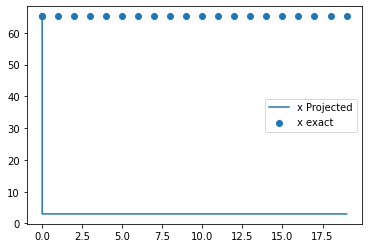

In [42]:
## haciendolo de mi forma, usando n_body_basis(2) y usando un estado gaussiano "chiquito". Da re mal el x

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30


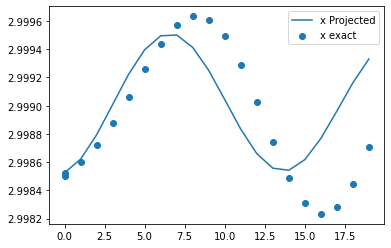

In [45]:
## Usando la forma de Mauricio, usando two_site_orth_basis

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30


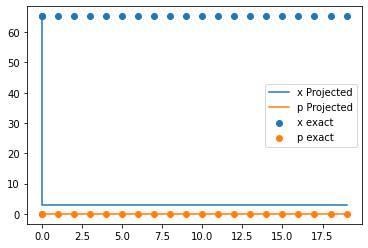

In [49]:
## En estas simus usé  rho0 = psi0 * psi0.dag() con rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.legend()

plt.legend()

sampling: 30
sampling: 30


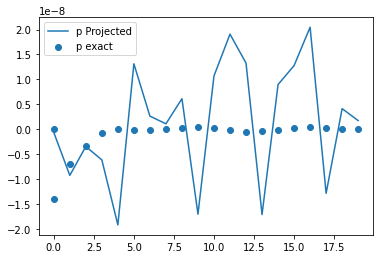

In [52]:
## Ídem que el caso anterior, pero ahora miro el p
## En estas simus usé  rho0 = psi0 * psi0.dag() con rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N. 

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30


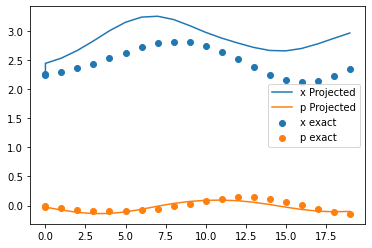

In [56]:
## á la Mauricio

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
sampling: 30


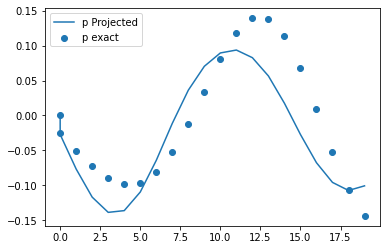

In [57]:
## Caso especial del p para las mismas conds anteriores
## usé me.initial_state_glng(N, .5, psi0, gaussian, sx_list, sy_list, sz_list) con gaussian = True

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30


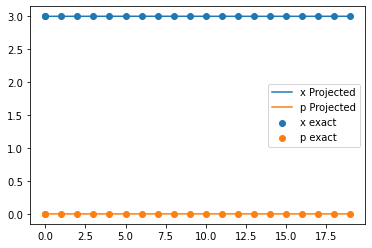

In [60]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
0.16791281322515023
0.025001997406236265
1.1487922825146764e-14
6.8329179718224e-05
1.0588064054146225e-07
1.0943601382025009e-06
3.837837843749808e-10
2.847322548963192e-11
-2.2674686255129694e-15
2.7230410245496378e-11
-1.1644215232581642e-15
3.4559150475658025e-11
-5.1809250033609207e-17
8.181803138401406e-14
4.2894135173715545e-09
-2.383026334279759e-15
3.832498575379521e-09
8.123253432665382e-14
2.1812800401946557e-12
7.543808212634594e-07
sampling: 30
1.5366498967615803
1.5366499211623428
1.5366499466148518
1.5366499734312118
1.536650000136888
1.5366500264372303
1.5366500535076661
1.536650082456855
1.5366501140063615
1.536650147568085
1.5366501820076974
1.5366502160147812
1.536650248583973
1.5366502798835635
1.5366503103435414
1.5366503679168246
1.5366504130072236
1.53665045978774
1.5366505052109396
1.536650562763997
sampling: 30
0.16791281322515023
0.025001997406236265
1.1487922825146764e-14
6.8329179718224e-05
1.0588064054146225e-07
1.0943601382025009e-06
3.8378378

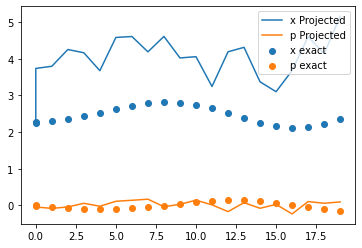

In [14]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
1.7623634883935035e-09
8.897276858776116e-10
4.0917825143476267e-13
0.634941571710568
1.548026520839077e-10
0.0026295518333333194
2.2034393346722337e-05
1.1825901929862861e-08
8.712039898658134e-15
6.019306388819321e-08
0.00010048180477350866
0.0004313182182275918
-1.1745602108609705e-16
2.0233857767965332e-13
2.585309419276434e-13
1.5292363500367864e-08
-1.4304389024841682e-15
0.040447956723005135
1.8827747953697937e-14
7.894600762081582e-11
sampling: 30
-167.74431341057016
-167.7443005949237
-167.74428790881026
-167.74427547859636
-167.7442632845791
-167.74425123615367
-167.7442392875691
-167.74422738667542
-167.7442154242809
-167.74419638623513
-167.7441840501636
-167.7441715761534
-167.7441588842844
-167.74414600644258
-167.744133022612
-167.74411984776847
-167.74410636932714
-167.7440928165316
-167.74407932293536
-167.74406533539172
sampling: 30
1.7623634883935035e-09
8.897276858776116e-10
4.0917825143476267e-13
0.634941571710568
1.548026520839077e-10
0.00262955183333

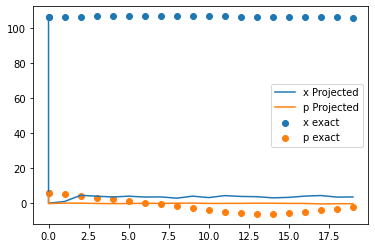

In [15]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=True, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
sampling: 30


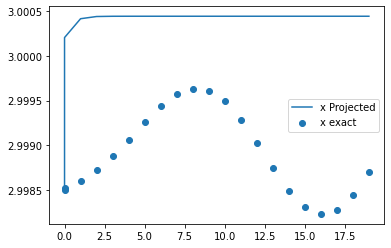

In [21]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

In [40]:
## La versión de Mauricio

def callback(t, rhot):
    global rho
    rho = rhot


def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=me.bures, do_project=True):
    global rho
    H_H = Heisenberg_hamiltonian(N,Jx,Jy,Jz,h)
    globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    # Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 

    rho0 = psi0 * psi0.dag()
    rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    #basis = sx_list +  sy_list + sz_list
    # basis = base_orth([x_op, p_op, x_op**2, corr_xp, p_dot, p_op**2, p_dot**2, p_op*H_H+H_H*p_op,1j*(p_op*H_H-H_H*p_op) ],rho0)

    # basis = base_orth(two_site_basis + [ H_H*op+op*H_H for op in two_site_basis ], rho0)
    basis = me.base_orth(two_site_basis, rho0)
    # Hamiltoniano    

    obs = [x_op, p_op]
           #, x_op**2,p_op**2, corr_op, p_dot]

    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            e0 = max(rho.eigenenergies())
            rho = rho - globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
2.0794396190490816
2.0794397731683754
2.0794398781648535
2.0794399504299896
2.079440016028118
2.0794400812455
2.079440135655471
2.079440181000524
2.079440230443113
2.0794402847590328
2.0794403321892663
2.079440368293514
2.079440398345729
2.0794404237006128
2.0794404409018017
2.0794404520715286
2.079440463916649
2.0794404775189834
2.079440488316501
2.079440495052855
sampling: 30
2.079438048642364
2.079438048631806
2.0794380486193496
2.079438048606403
2.079438048591962
2.079438048575193
2.0794380485572383
2.0794380485382518
2.079438048517046
2.079438048493923
2.0794380484696626
2.079438048443511
2.0794380484150174
2.0794380483849837
2.079438048353498
2.0794380483199006
2.0794380482845365
2.079438048247969
2.0794380482096737
2.079438048169335


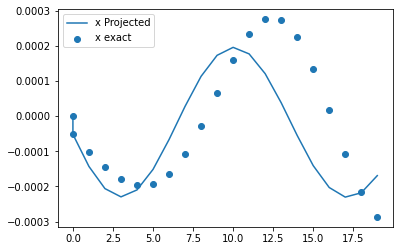

In [44]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,1], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="x exact")
plt.legend()


In [ ]:
help(qutip.entropy)

Help on module qutip.entropy in qutip:

NAME
    qutip.entropy

FUNCTIONS
    concurrence(rho)
        Calculate the concurrence entanglement measure for a two-qubit state.
        
        Parameters
        ----------
        state : qobj
            Ket, bra, or density matrix for a two-qubit state.
        
        Returns
        -------
        concur : float
            Concurrence
        
        References
        ----------
        
        .. [1] https://en.wikipedia.org/wiki/Concurrence_(quantum_computing)
    
    entangling_power(U)
        Calculate the entangling power of a two-qubit gate U, which
        is zero of nonentangling gates and 1 and 2/9 for maximally
        entangling gates.
        
        Parameters
        ----------
        U : qobj
            Qobj instance representing a two-qubit gate.
        
        Returns
        -------
        ep : float
            The entanglement power of U (real number between 0 and 1)
        
        References:
     

In [ ]:
c_op_list = spin_dephasing(.1)
[type(o) for o in c_op_list]

[qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj]

In [80]:
print(p_dot)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-0.09869604  0.          0.         -2.52908613  0.          0.19739209
  -1.51745168  0.        ]
 [ 0.          0.16038107 -0.04934802  0.         -0.04934802  0.
   0.         -1.44342964]
 [ 0.         -0.04934802  0.          0.          0.04934802  0.
   0.         -0.19739209]
 [-2.52908613  0.          0.          0.25907712  0.         -0.04934802
   0.04934802  0.        ]
 [ 0.         -0.04934802  0.04934802  0.         -0.25907712  0.
   0.         -2.40571607]
 [ 0.19739209  0.          0.         -0.04934802  0.          0.
   0.04934802  0.        ]
 [-1.51745168  0.          0.          0.04934802  0.          0.04934802
  -0.16038107  0.        ]
 [ 0.         -1.44342964 -0.19739209  0.         -2.40571607  0.
   0.          0.09869604]]


In [61]:
print(r"$$S(\psi_01)=$$", qutip.entropy_vn(psi01))
print(r"$$S(\psi_02)=$$", qutip.entropy_vn(psi02))
print(r"$$S(\psi_01+\psi_02)=$$", qutip.entropy_vn(psi01))

$$S(\psi_01)=$$ -0.0
$$S(\psi_02)=$$ -0.0
$$S(\psi_01+\psi_02)=$$ -0.0


In [62]:
print('Test 1: 1-bases iguales?', n_body_basis(1) == one_site_basis)
print('Test 1: 1-base igual a 2-base?', n_body_basis(1) == two_site_basis)
print('Test 2: 2-bases iguales?', n_body_basis(2) == two_site_basis)
print('Test 3: 3-bases iguales?', n_body_basis(3) == three_site_basis)
print('Test 4: 4-bases iguales?', n_body_basis(4) == four_site_basis)
n_body_basis(3) == two_site_basis

Test 1: 1-bases iguales? True
Test 1: 1-base igual a 2-base? False
Test 2: 2-bases iguales? True
Test 3: 3-bases iguales? True
Test 4: 4-bases iguales? True


False